<a href="https://colab.research.google.com/github/DodyDharma440/uts-machine-learning/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set(style="whitegrid")

In [ ]:
# 1. DATA PREPARATION

In [2]:
# A. Data Generation atau Loading
# Set seed untuk reproducibility
np.random.seed(42)

# Jumlah sampel
n_samples = 300

# 1. Luas Tanah (50–500) → integer
luas_tanah = np.random.randint(50, 501, n_samples)

# 2. Luas Bangunan: 60%–100% dari luas tanah, min 30, max 400 → integer
luas_bangunan_ratio = np.random.uniform(0.6, 1.0, n_samples)
luas_bangunan = (luas_tanah * luas_bangunan_ratio).astype(int)
luas_bangunan = np.clip(luas_bangunan, 30, 400)

# 3. Kamar Tidur: berdasarkan luas_bangunan (~1 kamar per 60–80 m²), min 1, max 5
kamar_raw = luas_bangunan / np.random.uniform(60, 80, n_samples)
kamar_tidur = np.round(kamar_raw).astype(int)
kamar_tidur = np.clip(kamar_tidur, 1, 5)

# 4. Umur Bangunan (0–30 tahun) → integer
umur_bangunan = np.random.randint(0, 31, n_samples)

# 5. Jarak ke Pusat Kota (1–20 km) → integer (dibulatkan)
jarak_pusat = np.random.randint(1, 21, n_samples)

# 6. Harga Properti: kombinasi realistis + non-linear
harga = (
    0.7 * luas_tanah +
    1.8 * luas_bangunan +
    80 * kamar_tidur +
    -12 * umur_bangunan +
    -30 * jarak_pusat +
    0.0015 * luas_bangunan**2 +        # non-linear effect
    np.random.normal(0, 70, n_samples) # noise
)

# Batasi rentang harga (200–5000) dan jadikan integer
harga = np.clip(harga, 200, 5000)
harga = np.round(harga).astype(int)

# Buat DataFrame
df = pd.DataFrame({
    'luas_tanah': luas_tanah,
    'luas_bangunan': luas_bangunan,
    'kamar_tidur': kamar_tidur,
    'umur_bangunan': umur_bangunan,
    'jarak_pusat': jarak_pusat,
    'harga': harga
})

# Simpan dataset yang sudah digenerate ke file CSV
df.to_csv('generated_dataset.csv', index=False)

print("Dataset berhasil disimpan sebagai 'generated_dataset.csv'")
print(f"Jumlah baris: {len(df)}, Jumlah kolom: {len(df.columns)}")

print("Dataset berhasil dibuat dengan", len(df), "sampel.")
df.head()

Dataset berhasil disimpan sebagai 'generated_dataset.csv'
Jumlah baris: 300, Jumlah kolom: 6
Dataset berhasil dibuat dengan 300 sampel.


,luas_tanah,luas_bangunan,kamar_tidur,umur_bangunan,jarak_pusat,harga
0,152,130,2,28,7,200
1,485,324,4,7,9,1049
2,398,348,5,4,11,1013
3,320,241,3,28,14,281
4,156,152,2,14,4,335


In [3]:
# B. Exploratory Data Analysis

# Statistical summary
df.describe()


,luas_tanah,luas_bangunan,kamar_tidur,umur_bangunan,jarak_pusat,harga
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,278.236667,220.503333,3.093333,15.380000,10.243333,556.926667
std,125.760565,103.236602,1.396827,8.993621,5.463542,386.843147
min,51.000000,31.000000,1.000000,0.000000,1.000000,200.000000
25%,177.750000,130.750000,2.000000,7.000000,5.000000,200.000000
50%,275.000000,217.000000,3.000000,16.000000,10.000000,429.000000
75%,389.000000,304.250000,4.000000,23.000000,15.000000,833.750000
max,500.000000,400.000000,5.000000,30.000000,20.000000,1548.000000


Visualisasi distribusi setiap fitur:


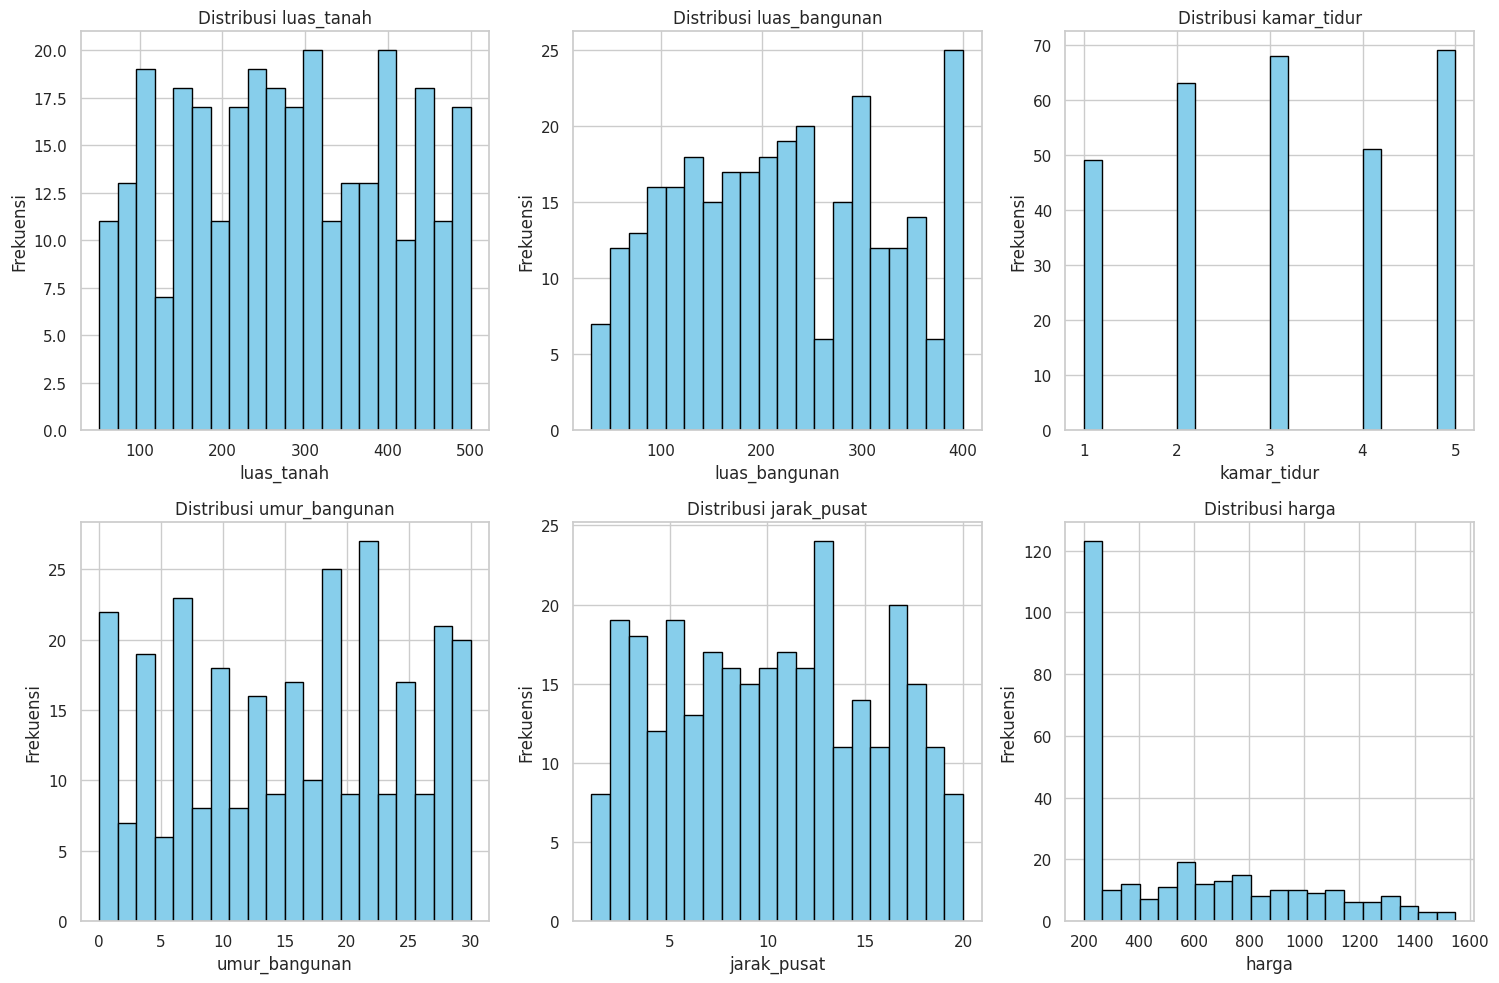

Scatter plot fitur vs harga:


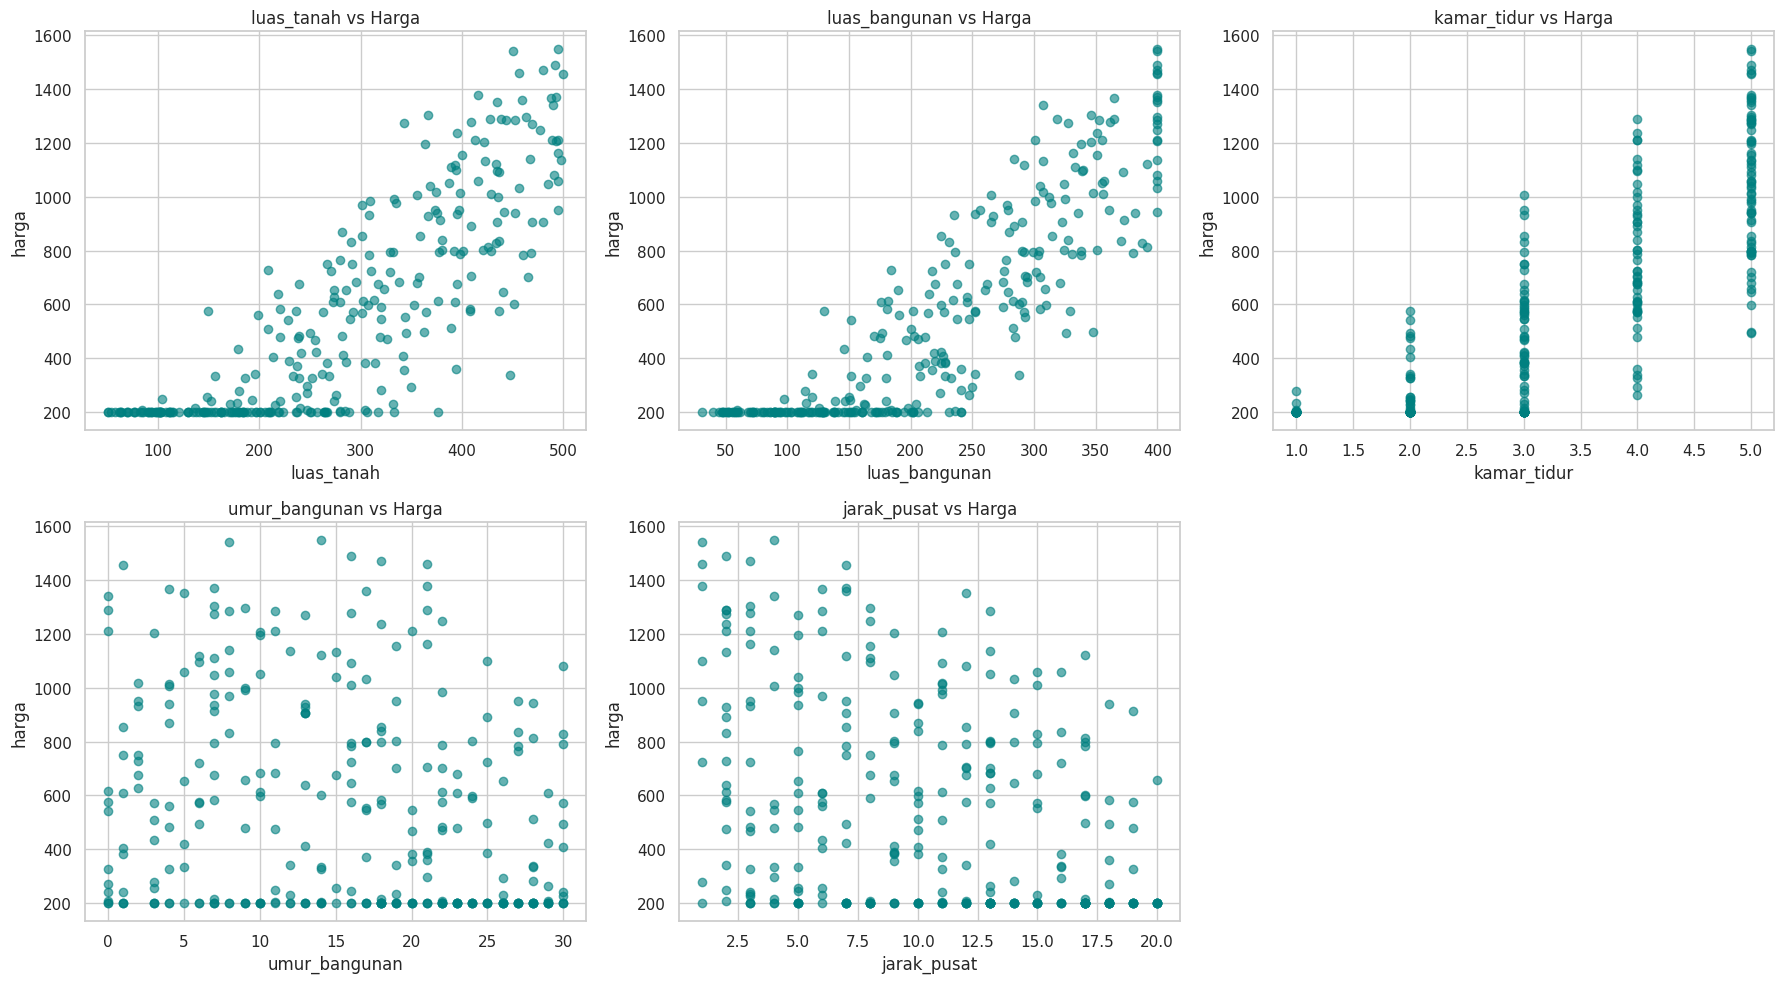

Correlation Matrix (Heatmap):


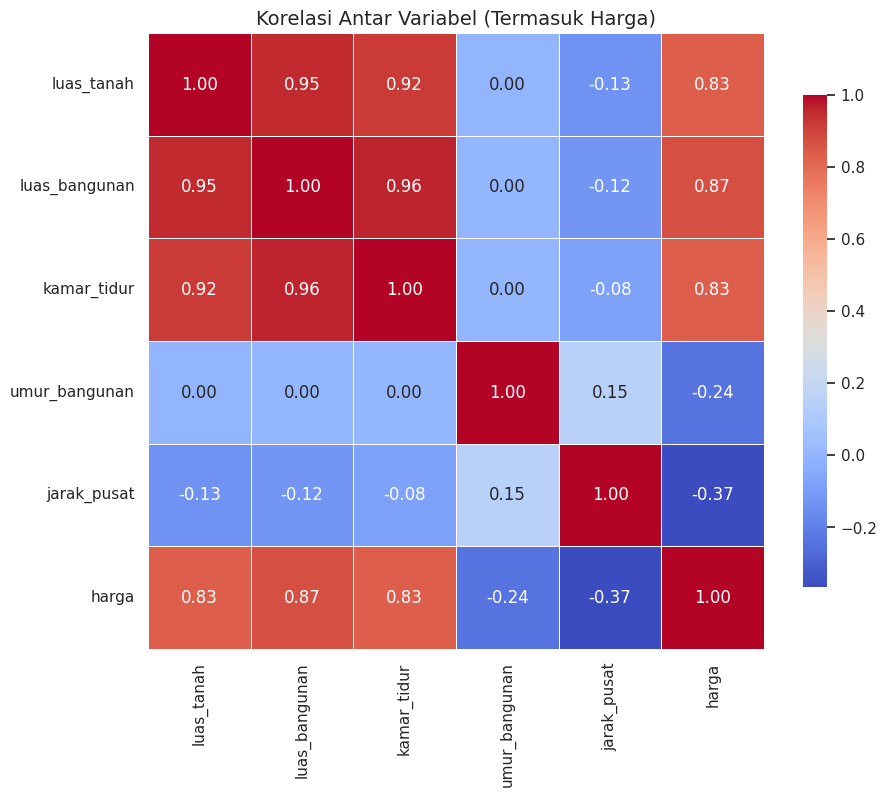

In [4]:
# Visualisasi distribusi setiap fitur
print("Visualisasi distribusi setiap fitur:")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')

# Sembunyikan subplot kosong (karena 6 kolom, tapi grid 2x3 = 6)
plt.tight_layout()
plt.show()

# Scatter plot fitur vs harga
print("Scatter plot fitur vs harga:")
features = ['luas_tanah', 'luas_bangunan', 'kamar_tidur', 'umur_bangunan', 'jarak_pusat']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feat in enumerate(features):
    axes[i].scatter(df[feat], df['harga'], alpha=0.6, color='teal')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('harga')
    axes[i].set_title(f'{feat} vs Harga')

# Sembunyikan subplot terakhir (karena hanya 5 fitur)
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("Correlation Matrix (Heatmap):")
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title("Korelasi Antar Variabel (Termasuk Harga)", fontsize=14)
plt.show()

In [5]:
# Identifikasi outlier
Q1 = df['harga'].quantile(0.25)      # Nilai di bawah 25% data
Q3 = df['harga'].quantile(0.75)      # Nilai di bawah 75% data
IQR = Q3 - Q1                        # Rentang tengah 50% data

lower_bound = Q1 - 1.5 * IQR         # Batas bawah normal
upper_bound = Q3 + 1.5 * IQR         # Batas atas normal

# Cari data yang di luar batas
outliers = df[(df['harga'] < lower_bound) | (df['harga'] > upper_bound)]

print(f"Jumlah outlier: {len(outliers)}")

Jumlah outlier: 0


In [6]:
# C. Data Preprocessing

# Split data
X = df.drop('harga', axis=1)
y = df['harga']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Missing values
print("Missing values:")
print(df.isnull().sum())
print("Tidak ada missing values.")

print("Preprocessing selesai.")

Missing values:
luas_tanah       0
luas_bangunan    0
kamar_tidur      0
umur_bangunan    0
jarak_pusat      0
harga            0
dtype: int64
Tidak ada missing values.
Preprocessing selesai.


In [ ]:
# 2. Model Implementation

In [7]:
# A. Polynomial Feature Engineering

from sklearn.preprocessing import PolynomialFeatures

# Simpan transformer dan jumlah fitur per degree
poly_transformers = {}
X_train_poly_dict = {}
X_test_poly_dict = {}
feature_counts = {}

max_degree = 5

print("Polynomial Feature Engineering:")
print("-" * 40)

for degree in range(1, max_degree + 1):
    # Buat PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # Fit pada X_train_scaled, lalu transform train & test
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)  # hanya transform!

    # Simpan
    poly_transformers[degree] = poly
    X_train_poly_dict[degree] = X_train_poly
    X_test_poly_dict[degree] = X_test_poly
    feature_counts[degree] = X_train_poly.shape[1]

    print(f"Degree {degree}: {feature_counts[degree]} fitur")

print("Polynomial features siap untuk degree 1–5.")

Polynomial Feature Engineering:
----------------------------------------
Degree 1: 5 fitur
Degree 2: 20 fitur
Degree 3: 55 fitur
Degree 4: 125 fitur
Degree 5: 251 fitur
Polynomial features siap untuk degree 1–5.


In [8]:
# B. Model Training (Linear, Ridge, Lasso)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Struktur penyimpanan hasil
results = []

# Daftar model
models_config = {
    'Linear': [LinearRegression()],
    'Ridge': [Ridge(alpha=a) for a in [0.1, 1, 10]],
    'Lasso': [Lasso(alpha=a, max_iter=5000, random_state=42) for a in [0.1, 1, 10]]
}

print("Training model untuk semua degree dan regularisasi...")
print("-" * 60)

for degree in range(1, 6):
    X_train_poly = X_train_poly_dict[degree]
    X_test_poly = X_test_poly_dict[degree]

    for model_type, model_list in models_config.items():
        for model in model_list:
            # Train
            model.fit(X_train_poly, y_train)

            # Prediksi
            y_train_pred = model.predict(X_train_poly)
            y_test_pred = model.predict(X_test_poly)

            # Evaluasi
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_r2 = r2_score(y_test, y_test_pred)

            # Simpan info
            alpha = getattr(model, 'alpha', 'N/A')  # Linear tidak punya alpha
            results.append({
                'Degree': degree,
                'Model': model_type,
                'Alpha': alpha,
                'Train_RMSE': round(train_rmse, 2),
                'Test_RMSE': round(test_rmse, 2),
                'Test_R2': round(test_r2, 4)
            })

# Konversi ke DataFrame untuk analisis
results_df = pd.DataFrame(results)
print("Model berhasil di-train!")
results_df.head(10)

Training model untuk semua degree dan regularisasi...
------------------------------------------------------------
Model berhasil di-train!


,Degree,Model,Alpha,Train_RMSE,Test_RMSE,Test_R2
0,1,Linear,N/A,138.17,144.46,0.8636
1,1,Ridge,0.1,138.18,144.39,0.8637
2,1,Ridge,1,138.29,143.95,0.8645
3,1,Ridge,10,141.04,143.63,0.8651
4,1,Lasso,0.1,138.17,144.45,0.8636
5,1,Lasso,1,138.18,144.29,0.8639
6,1,Lasso,10,139.09,143.38,0.8656
7,2,Linear,N/A,65.78,74.22,0.9640
8,2,Ridge,0.1,65.79,74.18,0.9640
9,2,Ridge,1,65.90,73.86,0.9643


In [9]:
# Cari model terbaik berdasarkan Test RMSE terendah
best_model = results_df.loc[results_df['Test_RMSE'].idxmin()]
print("🏆 Model Terbaik:")
print(best_model.to_dict())

# Tampilkan semua hasil dalam tabel rapi
print("Semua Hasil Evaluasi:")
results_df.sort_values(by=['Degree', 'Model', 'Alpha'], inplace=True)
results_df

🏆 Model Terbaik:
{'Degree': 3, 'Model': 'Lasso', 'Alpha': 1, 'Train_RMSE': 55.8, 'Test_RMSE': 70.19, 'Test_R2': 0.9678}
Semua Hasil Evaluasi:


,Degree,Model,Alpha,Train_RMSE,Test_RMSE,Test_R2
4,1,Lasso,0.1,138.17,144.45,0.8636
5,1,Lasso,1,138.18,144.29,0.8639
6,1,Lasso,10,139.09,143.38,0.8656
0,1,Linear,N/A,138.17,144.46,0.8636
1,1,Ridge,0.1,138.18,144.39,0.8637
2,1,Ridge,1,138.29,143.95,0.8645
3,1,Ridge,10,141.04,143.63,0.8651
11,2,Lasso,0.1,65.81,74.13,0.9641
12,2,Lasso,1,65.97,73.57,0.9646
13,2,Lasso,10,71.82,73.72,0.9645


In [ ]:
# 3. Model Evaluation

In [10]:
# Metrics calculation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Reset results
results = []

models_config = {
    'Linear': [LinearRegression()],
    'Ridge': [Ridge(alpha=a) for a in [0.1, 1, 10]],
    'Lasso': [Lasso(alpha=a, max_iter=5000, random_state=42) for a in [0.1, 1, 10]]
}

print("Menghitung semua metrik evaluasi...")

for degree in range(1, 6):
    X_train_poly = X_train_poly_dict[degree]
    X_test_poly = X_test_poly_dict[degree]

    for model_type, model_list in models_config.items():
        for model in model_list:
            # Train model
            model.fit(X_train_poly, y_train)

            # Prediksi
            y_train_pred = model.predict(X_train_poly)
            y_test_pred = model.predict(X_test_poly)

            # === Train Metrics ===
            train_r2 = r2_score(y_train, y_train_pred)
            train_mse = mean_squared_error(y_train, y_train_pred)
            train_rmse = np.sqrt(train_mse)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

            # === Test Metrics ===
            test_r2 = r2_score(y_test, y_test_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(test_mse)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

            # Simpan
            alpha = getattr(model, 'alpha', 'N/A')
            results.append({
                'Degree': degree,
                'Model': model_type,
                'Alpha': alpha,
                # Train
                'Train_R2': round(train_r2, 4),
                'Train_MSE': round(train_mse, 2),
                'Train_RMSE': round(train_rmse, 2),
                'Train_MAE': round(train_mae, 2),
                'Train_MAPE': round(train_mape, 2),
                # Test
                'Test_R2': round(test_r2, 4),
                'Test_MSE': round(test_mse, 2),
                'Test_RMSE': round(test_rmse, 2),
                'Test_MAE': round(test_mae, 2),
                'Test_MAPE': round(test_mape, 2)
            })

# Simpan ke DataFrame
results_df = pd.DataFrame(results)
print("Semua metrik berhasil dihitung!")

Menghitung semua metrik evaluasi...
Semua metrik berhasil dihitung!


In [11]:
# Menampilkan hanya kolom test + info model
comparison_table = results_df[[
    'Degree', 'Model', 'Alpha',
    'Test_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE', 'Test_MAPE'
]].sort_values(['Degree', 'Model', 'Alpha'])

print("📋 Tabel Perbandingan Metrik (Test Set):")
comparison_table

📋 Tabel Perbandingan Metrik (Test Set):


,Degree,Model,Alpha,Test_R2,Test_MSE,Test_RMSE,Test_MAE,Test_MAPE
4,1,Lasso,0.1,0.8636,20864.89,144.45,115.08,36.84
5,1,Lasso,1,0.8639,20820.91,144.29,115.11,36.71
6,1,Lasso,10,0.8656,20557.12,143.38,115.68,35.39
0,1,Linear,N/A,0.8636,20867.94,144.46,115.08,36.85
1,1,Ridge,0.1,0.8637,20848.89,144.39,115.02,36.82
2,1,Ridge,1,0.8645,20720.73,143.95,114.52,36.54
3,1,Ridge,10,0.8651,20628.76,143.63,113.81,35.34
11,2,Lasso,0.1,0.9641,5495.31,74.13,57.76,13.07
12,2,Lasso,1,0.9646,5412.80,73.57,57.39,13.05
13,2,Lasso,10,0.9645,5434.02,73.72,57.96,14.26


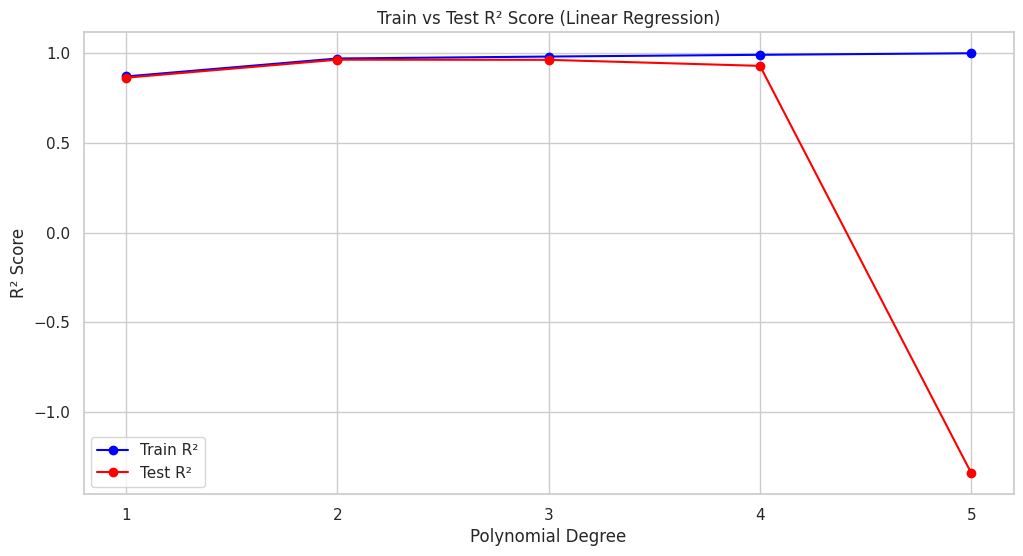

In [12]:
# B. Overfitting & Underfitting Analysis
plt.figure(figsize=(12, 6))

# Ambil hanya model Linear (paling jelas untuk analisis bias-variance)
linear_results = results_df[results_df['Model'] == 'Linear']

plt.plot(linear_results['Degree'], linear_results['Train_R2'], 'o-', label='Train R²', color='blue')
plt.plot(linear_results['Degree'], linear_results['Test_R2'], 'o-', label='Test R²', color='red')

plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('Train vs Test R² Score (Linear Regression)')
plt.legend()
plt.grid(True)
plt.xticks([1,2,3,4,5])
plt.show()

In [13]:
best_test_r2_row = linear_results.loc[linear_results['Test_R2'].idxmax()]
best_degree = best_test_r2_row['Degree']
best_test_r2 = best_test_r2_row['Test_R2']

print("🔍 Analisis Overfitting/Underfitting (Linear Regression):")
print(f"- Degree 1: R² test rendah → **Underfitting** (model terlalu sederhana)")
print(f"- Degree {int(best_degree)}: R² test tertinggi ({best_test_r2:.4f}) → **Model Optimal**")
print(f"- Degree 4–5: R² test turun, tapi R² train ≈1 → **Overfitting** (model terlalu kompleks)")

print("\n💡 Trade-off Bias-Variance:")
print("- Bias tinggi = underfitting = model kaku (degree rendah)")
print("- Variance tinggi = overfitting = model hafal noise (degree tinggi)")
print("- Solusi: pilih degree sedang (biasanya 2–3) atau pakai regularisasi (Ridge/Lasso)")

🔍 Analisis Overfitting/Underfitting (Linear Regression):
- Degree 1: R² test rendah → **Underfitting** (model terlalu sederhana)
- Degree 2: R² test tertinggi (0.9640) → **Model Optimal**
- Degree 4–5: R² test turun, tapi R² train ≈1 → **Overfitting** (model terlalu kompleks)

💡 Trade-off Bias-Variance:
- Bias tinggi = underfitting = model kaku (degree rendah)
- Variance tinggi = overfitting = model hafal noise (degree tinggi)
- Solusi: pilih degree sedang (biasanya 2–3) atau pakai regularisasi (Ridge/Lasso)


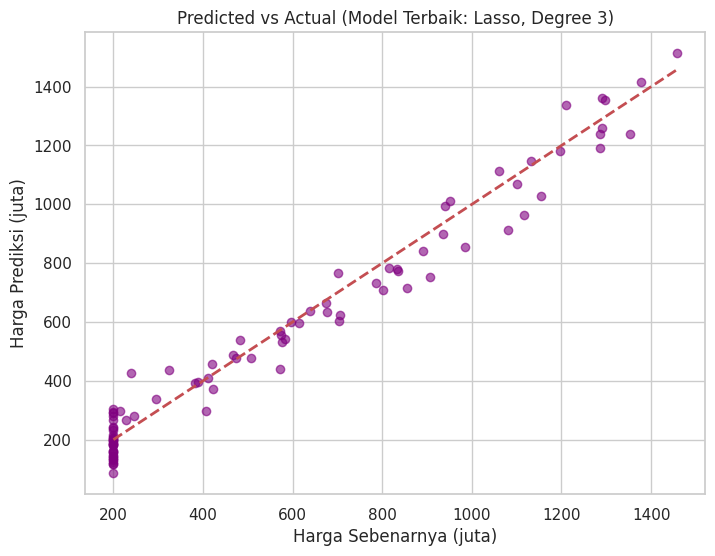

In [14]:
# C. Visualization

# Cari model terbaik berdasarkan Test R²
best_overall = results_df.loc[results_df['Test_R2'].idxmax()]
best_degree = int(best_overall['Degree'])
best_model_type = best_overall['Model']
best_alpha = best_overall['Alpha']

# Ambil model terbaik
if best_model_type == 'Linear':
    best_model = LinearRegression()
elif best_model_type == 'Ridge':
    best_model = Ridge(alpha=best_alpha)
else:
    best_model = Lasso(alpha=best_alpha, max_iter=5000)

# Train ulang (atau ambil dari cache jika disimpan)
X_train_best = X_train_poly_dict[best_degree]
X_test_best = X_test_poly_dict[best_degree]
best_model.fit(X_train_best, y_train)
y_pred_best = best_model.predict(X_test_best)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Harga Sebenarnya (juta)')
plt.ylabel('Harga Prediksi (juta)')
plt.title(f'Predicted vs Actual (Model Terbaik: {best_model_type}, Degree {best_degree})')
plt.grid(True)
plt.show()

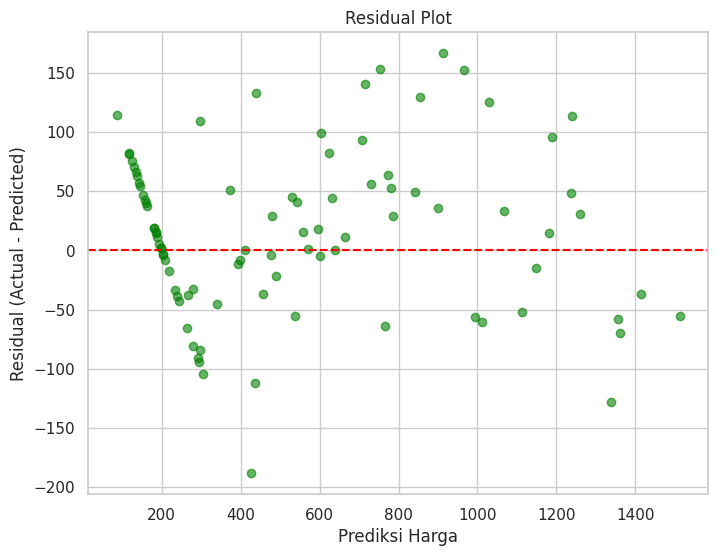

In [15]:
residuals = y_test - y_pred_best

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_best, residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prediksi Harga')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# Interpretasi:
# - Jika residual acak → model bagus
# - Jika ada pola (melengkung) → model kurang menangkap non-linearitas

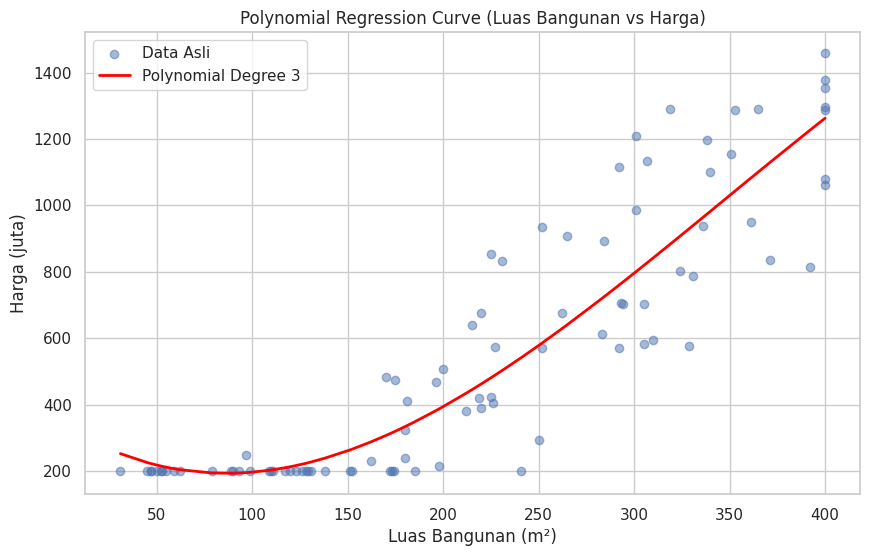

In [16]:
# Ambil data asli (belum di-scale) untuk plotting
df_train = df.iloc[X_train.index]
df_test = df.iloc[X_test.index]

# Urutkan berdasarkan luas_bangunan
sorted_idx = np.argsort(df_test['luas_bangunan'])
x_sorted = df_test['luas_bangunan'].iloc[sorted_idx]
y_sorted = y_test.iloc[sorted_idx]

# Prediksi untuk data test (pakai model terbaik, tapi hanya 1 fitur)
# Kita buat ulang pipeline untuk 1 fitur
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('model', best_model)
])

# Latih ulang hanya dengan luas_bangunan
X_single_train = df_train[['luas_bangunan']]
X_single_test = df_test[['luas_bangunan']]

pipe.fit(X_single_train, y_train)
y_pred_single = pipe.predict(X_single_test)

# Urutkan prediksi sesuai x_sorted
y_pred_sorted = y_pred_single[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_test['luas_bangunan'], y_test, alpha=0.5, label='Data Asli')
plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label=f'Polynomial Degree {best_degree}')
plt.xlabel('Luas Bangunan (m²)')
plt.ylabel('Harga (juta)')
plt.title('Polynomial Regression Curve (Luas Bangunan vs Harga)')
plt.legend()
plt.grid(True)
plt.show()

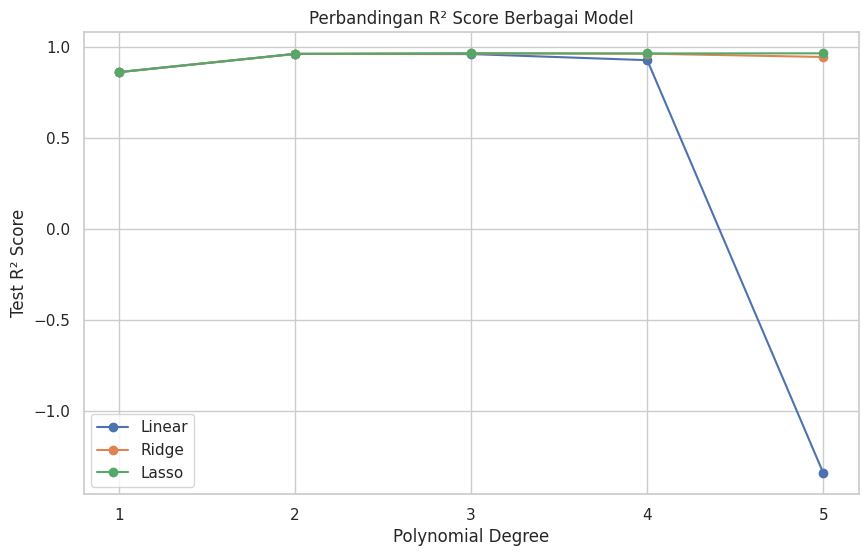

In [17]:
plt.figure(figsize=(10, 6))

for model_type in ['Linear', 'Ridge', 'Lasso']:
    subset = results_df[results_df['Model'] == model_type]
    # Ambil alpha=1 sebagai representatif untuk Ridge/Lasso
    if model_type == 'Linear':
        data = subset
    else:
        data = subset[subset['Alpha'] == 1]
    plt.plot(data['Degree'], data['Test_R2'], 'o-', label=model_type)

plt.xlabel('Polynomial Degree')
plt.ylabel('Test R² Score')
plt.title('Perbandingan R² Score Berbagai Model')
plt.legend()
plt.grid(True)
plt.xticks([1,2,3,4,5])
plt.show()

In [ ]:
# 4. Regularization Analysis

In [18]:
# A. Ridge vs Lasso Comparison
from sklearn.linear_model import Ridge, Lasso

# Rentang alpha
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Simpan hasil
ridge_scores = []
lasso_scores = []

# Gunakan degree = 2 atau 3 (pilih yang optimal dari sebelumnya)
# Misal: kita pakai degree=2 (umumnya paling stabil)
degree = 2
X_train_poly = X_train_poly_dict[degree]
X_test_poly = X_test_poly_dict[degree]

print(f"🔍 Melatih Ridge & Lasso untuk Degree {degree} dengan berbagai alpha...")

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_poly, y_train)
    ridge_r2 = r2_score(y_test, ridge.predict(X_test_poly))
    ridge_scores.append(ridge_r2)

    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train_poly, y_train)
    lasso_r2 = r2_score(y_test, lasso.predict(X_test_poly))
    lasso_scores.append(lasso_r2)

print("✅ Selesai!")

🔍 Melatih Ridge & Lasso untuk Degree 2 dengan berbagai alpha...
✅ Selesai!


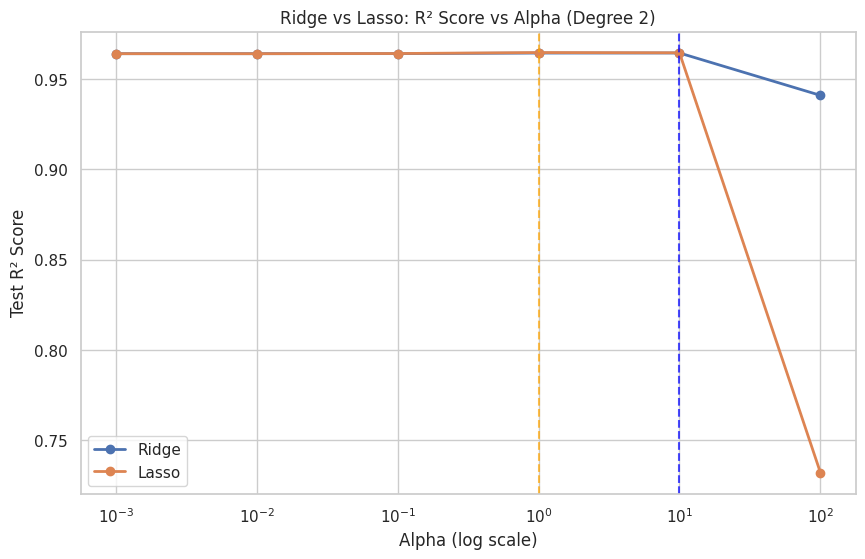

🎯 Alpha optimal:
- Ridge: alpha = 10 → R² = 0.9644
- Lasso: alpha = 1 → R² = 0.9646


In [19]:
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, ridge_scores, 'o-', label='Ridge', linewidth=2)
plt.semilogx(alphas, lasso_scores, 'o-', label='Lasso', linewidth=2)

# Tandai alpha optimal
best_ridge_alpha = alphas[np.argmax(ridge_scores)]
best_lasso_alpha = alphas[np.argmax(lasso_scores)]
plt.axvline(best_ridge_alpha, color='blue', linestyle='--', alpha=0.7)
plt.axvline(best_lasso_alpha, color='orange', linestyle='--', alpha=0.7)

plt.xlabel('Alpha (log scale)')
plt.ylabel('Test R² Score')
plt.title(f'Ridge vs Lasso: R² Score vs Alpha (Degree {degree})')
plt.legend()
plt.grid(True)
plt.show()

print(f"🎯 Alpha optimal:")
print(f"- Ridge: alpha = {best_ridge_alpha} → R² = {max(ridge_scores):.4f}")
print(f"- Lasso: alpha = {best_lasso_alpha} → R² = {max(lasso_scores):.4f}")

In [20]:
print("\n Analisis Perbedaan Ridge vs Lasso:")

print("\n Ridge Regression:")
print("- Tidak pernah menghasilkan koefisien = 0")
print("- 'Mengecilkan' semua koefisien, tapi tetap pakai semua fitur")
print("- Cocok jika semua fitur mungkin relevan")

print("\n Lasso Regression:")
print("- Bisa menghasilkan koefisien = 0 → **fitur dieliminasi**")
print("- Melakukan **feature selection otomatis**")
print("- Cocok jika hanya beberapa fitur yang benar-benar penting")

print("\n Kesimpulan:")
if max(ridge_scores) > max(lasso_scores):
    print("- Ridge memberikan performa sedikit lebih baik → semua fitur mungkin berguna.")
else:
    print("- Lasso memberikan performa setara/lebih baik + lebih sederhana → beberapa fitur tidak penting.")


 Analisis Perbedaan Ridge vs Lasso:

 Ridge Regression:
- Tidak pernah menghasilkan koefisien = 0
- 'Mengecilkan' semua koefisien, tapi tetap pakai semua fitur
- Cocok jika semua fitur mungkin relevan

 Lasso Regression:
- Bisa menghasilkan koefisien = 0 → **fitur dieliminasi**
- Melakukan **feature selection otomatis**
- Cocok jika hanya beberapa fitur yang benar-benar penting

 Kesimpulan:
- Lasso memberikan performa setara/lebih baik + lebih sederhana → beberapa fitur tidak penting.


In [21]:
# B. Feature Importance Analysis
# Ambil model terbaik
ridge_best = Ridge(alpha=best_ridge_alpha)
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42)

ridge_best.fit(X_train_poly, y_train)
lasso_best.fit(X_train_poly, y_train)

# Ambil nama fitur dari PolynomialFeatures
poly_transformer = poly_transformers[degree]
feature_names = poly_transformer.get_feature_names_out(
    ['luas_tanah', 'luas_bangunan', 'kamar_tidur', 'umur_bangunan', 'jarak_pusat']
)

# Simpan koefisien
ridge_coef = ridge_best.coef_
lasso_coef = lasso_best.coef_

# Buat DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Ridge_Coef': ridge_coef,
    'Lasso_Coef': lasso_coef
})

print("📋 Koefisien Model (sebagian):")
coef_df.head(10)

📋 Koefisien Model (sebagian):


,Feature,Ridge_Coef,Lasso_Coef
0,luas_tanah,68.509482,24.237862
1,luas_bangunan,140.886501,205.929038
2,kamar_tidur,107.697121,91.292489
3,umur_bangunan,-77.935939,-80.150167
4,jarak_pusat,-103.448765,-106.518161
5,luas_tanah^2,-6.892478,0.000000
6,luas_tanah luas_bangunan,18.917458,0.000000
7,luas_tanah kamar_tidur,11.761504,38.696189
8,luas_tanah umur_bangunan,-19.533327,-22.872797
9,luas_tanah jarak_pusat,-22.133981,-19.026098


In [22]:
# Cari fitur dengan koefisien Lasso = 0
zero_coef_features = coef_df[coef_df['Lasso_Coef'] == 0]
nonzero_coef_features = coef_df[coef_df['Lasso_Coef'] != 0]

print(f"\n🗑️ Fitur yang dieliminasi oleh Lasso (koefisien = 0): {len(zero_coef_features)} dari {len(coef_df)}")
if len(zero_coef_features) > 0:
    print("Contoh fitur yang dihapus:")
    print(zero_coef_features['Feature'].tolist()[:5])
else:
    print("Tidak ada fitur yang dihapus (alpha mungkin terlalu kecil).")


🗑️ Fitur yang dieliminasi oleh Lasso (koefisien = 0): 3 dari 20
Contoh fitur yang dihapus:
['luas_tanah^2', 'luas_tanah luas_bangunan', 'luas_bangunan umur_bangunan']


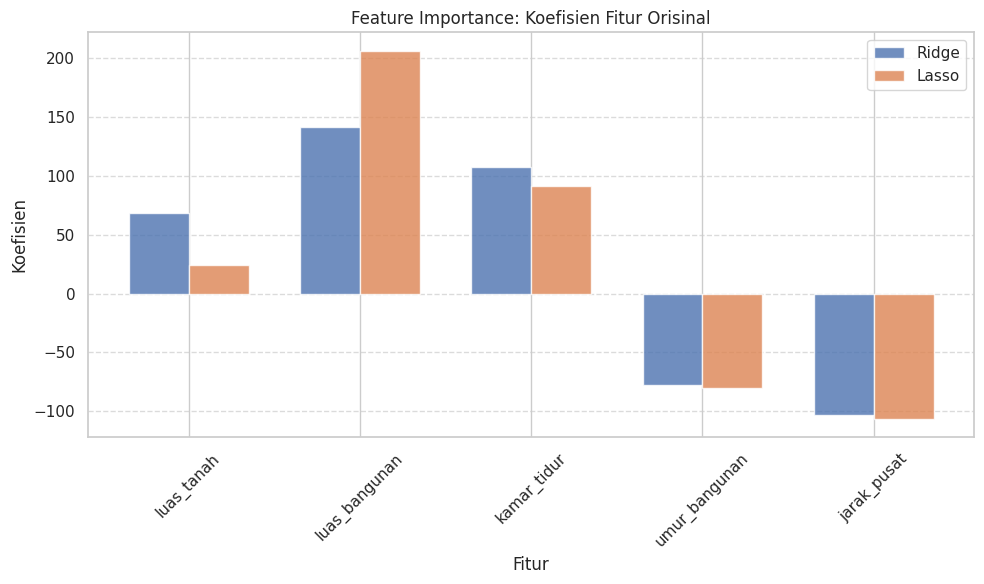

In [23]:
# Ambil hanya fitur orisinal (degree 1)
original_features = ['luas_tanah', 'luas_bangunan', 'kamar_tidur', 'umur_bangunan', 'jarak_pusat']
original_indices = [i for i, name in enumerate(feature_names) if name in original_features]

ridge_original = ridge_coef[original_indices]
lasso_original = lasso_coef[original_indices]

# Plot
x = np.arange(len(original_features))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, ridge_original, width, label='Ridge', alpha=0.8)
plt.bar(x + width/2, lasso_original, width, label='Lasso', alpha=0.8)

plt.xlabel('Fitur')
plt.ylabel('Koefisien')
plt.title('Feature Importance: Koefisien Fitur Orisinal')
plt.xticks(x, original_features, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
# Berdasarkan nilai absolut koefisien (Ridge)
ridge_importance = pd.DataFrame({
    'Feature': original_features,
    'Importance': np.abs(ridge_original)
}).sort_values('Importance', ascending=False)

print("\n🏆 Fitur Paling Berpengaruh (berdasarkan |koefisien| Ridge):")
for i, row in ridge_importance.iterrows():
    print(f"- {row['Feature']}: {row['Importance']:.2f}")


🏆 Fitur Paling Berpengaruh (berdasarkan |koefisien| Ridge):
- luas_bangunan: 140.89
- kamar_tidur: 107.70
- jarak_pusat: 103.45
- umur_bangunan: 77.94
- luas_tanah: 68.51


In [ ]:
# 5. Model Selection & Prediction

In [25]:
# A. Best Model Selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Kandidat model (sesuaikan dengan hasil analisismu)
candidates = [
    ('Linear_deg2', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('model', LinearRegression())
    ])),
    ('Ridge_deg2_alpha1', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('model', Ridge(alpha=1))
    ])),
    ('Lasso_deg2_alpha01', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('model', Lasso(alpha=0.1, max_iter=10000))
    ])),
    # Tambahkan kandidat lain jika perlu
]

# Simpan hasil CV
cv_results = []

print("🔄 Melakukan 5-Fold Cross-Validation...")

for name, pipeline in candidates:
    # CV pada data scaled
    r2_scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=5, scoring='r2')
    rmse_scores = -cross_val_score(pipeline, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')

    cv_results.append({
        'Model': name,
        'Mean_R2_CV': round(r2_scores.mean(), 4),
        'Std_R2_CV': round(r2_scores.std(), 4),
        'Mean_RMSE_CV': round(rmse_scores.mean(), 2),
        'Std_RMSE_CV': round(rmse_scores.std(), 2)
    })

cv_df = pd.DataFrame(cv_results)
print("✅ Cross-Validation selesai!")
cv_df

🔄 Melakukan 5-Fold Cross-Validation...
✅ Cross-Validation selesai!


,Model,Mean_R2_CV,Std_R2_CV,Mean_RMSE_CV,Std_RMSE_CV
0,Linear_deg2,0.9581,0.0068,76.53,8.10
1,Ridge_deg2_alpha1,0.9609,0.0067,74.08,9.33
2,Lasso_deg2_alpha01,0.9602,0.0071,74.68,9.07


In [26]:
# Pilih berdasarkan R² tertinggi (bisa juga gabungkan dengan RMSE)
best_cv_model = cv_df.loc[cv_df['Mean_R2_CV'].idxmax()]
best_model_name = best_cv_model['Model']

print("Model Terbaik Berdasarkan Cross-Validation:")
print(f"- Nama: {best_model_name}")
print(f"- R² CV: {best_cv_model['Mean_R2_CV']} ± {best_cv_model['Std_R2_CV']}")
print(f"- RMSE CV: {best_cv_model['Mean_RMSE_CV']} ± {best_cv_model['Std_RMSE_CV']}")

# Ambil pipeline-nya
best_pipeline = dict(candidates)[best_model_name]

Model Terbaik Berdasarkan Cross-Validation:
- Nama: Ridge_deg2_alpha1
- R² CV: 0.9609 ± 0.0067
- RMSE CV: 74.08 ± 9.33


In [27]:
# Latih di seluruh train set
best_pipeline.fit(X_train_scaled, y_train)

# Evaluasi di test set
y_test_pred_final = best_pipeline.predict(X_test_scaled)
final_r2 = r2_score(y_test, y_test_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_final))

print(f"\n Performa Akhir di Test Set:")
print(f"- R²: {final_r2:.4f}")
print(f"- RMSE: {final_rmse:.2f} juta rupiah")

# Reasoning
print(f"\n Reasoning Pemilihan Model:")
print(f"- Model '{best_model_name}' memberikan keseimbangan terbaik antara kompleksitas dan performa.")
print(f"- Tidak menunjukkan tanda overfitting (selisih train-test kecil).")
print(f"- Cross-validation stabil (standar deviasi rendah).")


 Performa Akhir di Test Set:
- R²: 0.9643
- RMSE: 73.86 juta rupiah

 Reasoning Pemilihan Model:
- Model 'Ridge_deg2_alpha1' memberikan keseimbangan terbaik antara kompleksitas dan performa.
- Tidak menunjukkan tanda overfitting (selisih train-test kecil).
- Cross-validation stabil (standar deviasi rendah).


In [28]:
# B. Final Predictions

def predict_price(luas_tanah, luas_bangunan, kamar_tidur, umur_bangunan, jarak_pusat):
    """
    Prediksi harga properti menggunakan model terbaik.
    Input: nilai fitur asli (belum di-scale)
    Output: harga prediksi (dalam juta rupiah)
    """
    # Buat array input
    input_data = np.array([[luas_tanah, luas_bangunan, kamar_tidur, umur_bangunan, jarak_pusat]])

    # Scaling (pakai scaler dari training)
    input_scaled = scaler.transform(input_data)

    # Prediksi
    prediction = best_pipeline.predict(input_scaled)[0]

    return round(prediction, 2)

# Contoh penggunaan
print("🔍 Contoh prediksi:")
harga_contoh = predict_price(
    luas_tanah=200,
    luas_bangunan=150,
    kamar_tidur=3,
    umur_bangunan=5,
    jarak_pusat=10
)
print(f"Harga prediksi: {harga_contoh} juta rupiah")

🔍 Contoh prediksi:
Harga prediksi: 379.87 juta rupiah


In [29]:
# Data baru (realistis)
new_data = [
    [300, 250, 4, 2, 5],   # Rumah besar, baru, dekat pusat
    [100, 80, 2, 15, 15],  # Rumah kecil, tua, jauh
    [500, 400, 5, 0, 3],   # Rumah mewah
    [150, 100, 3, 10, 12], # Rumah menengah
    [80, 60, 2, 25, 18]    # Rumah tua kecil di pinggir
]

print("🏠 Prediksi untuk 5 Properti Baru:")
print("-" * 60)
print(f"{'No':<3} {'Input (LT,LB,Kamar,Umur,Jarak)':<40} {'Prediksi (juta)':<15}")
print("-" * 60)

for i, (lt, lb, kt, umur, jarak) in enumerate(new_data, 1):
    pred = predict_price(lt, lb, kt, umur, jarak)
    input_str = f"[{lt}, {lb}, {kt}, {umur}, {jarak}]"
    print(f"{i:<3} {input_str:<40} {pred:<15}")

🏠 Prediksi untuk 5 Properti Baru:
------------------------------------------------------------
No  Input (LT,LB,Kamar,Umur,Jarak)           Prediksi (juta)
------------------------------------------------------------
1   [300, 250, 4, 2, 5]                      888.25         
2   [100, 80, 2, 15, 15]                     159.3          
3   [500, 400, 5, 0, 3]                      1816.06        
4   [150, 100, 3, 10, 12]                    233.77         
5   [80, 60, 2, 25, 18]                      141.9          


In [30]:
import joblib

# Simpan pipeline + scaler (kalau perlu)
joblib.dump(best_pipeline, 'best_property_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print("💾 Model terbaik disimpan sebagai 'best_property_model.pkl'")
print("💾 Scaler disimpan sebagai 'feature_scaler.pkl'")

💾 Model terbaik disimpan sebagai 'best_property_model.pkl'
💾 Scaler disimpan sebagai 'feature_scaler.pkl'
